In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [5]:
%load_ext autoreload
%autoreload 2
from preprocessing import *

/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [6]:
bad_worker_records_df = pd.read_csv("bad_worker_records.csv",index_col=0)
bad_worker_records = bad_worker_records_df.as_matrix()

In [7]:
easy_task_predicted_by_algo = [i for i in object_lst if i not in bad_worker_records_df["objid"].unique()]
print "easy tasks predicted by algo:",easy_task_predicted_by_algo
print "human-labelled easy tasks:",easy_tasks

easy tasks predicted by algo: [2, 3, 5, 6, 7, 8, 11, 12, 13, 14, 16, 17, 19, 23, 24, 25, 28, 32, 33, 36, 37, 38, 39, 43, 44, 45, 46]
human-labelled easy tasks: [2, 3, 5, 6, 11, 12, 13, 14, 16, 17, 19, 23, 24, 26, 36, 37, 38, 39, 43, 44, 45, 46]


__Uncaught errors: __
  - object 7, 8, 25 are type 2 errors uncaught because many workers are voting on bad regions
  - object 26 is supposed to be a two two error, but we mislabelled as easy (so our algo actually detect this!)
  - object 28, 32,33 has undetected type 2 errors (flower vase examples, very noisy)

In [8]:
type_one_task_ambiguity

[15, 20, 22, 27, 31, 40, 41, 42, 47]

In [9]:
bad_worker_records_df[bad_worker_records_df["error type"]==1]["objid"].unique()

array([15, 18, 20, 21, 22, 27, 29, 31, 42, 47])

__Other mistakes: __
 - Object 29,31 (vase) unable to identify type 2 error 
 - but strangely object 30 (also flower vase) seems to do a good job at identifying type 2 error
 - Object 47 unable to identify type 2 error

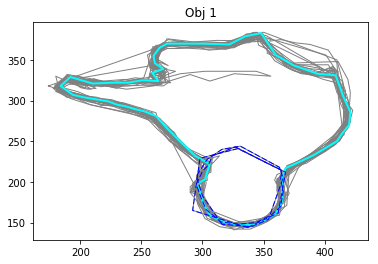

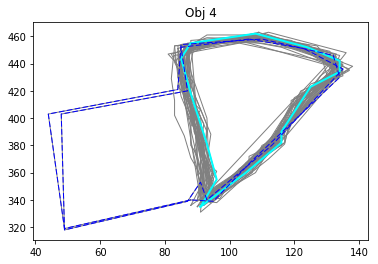

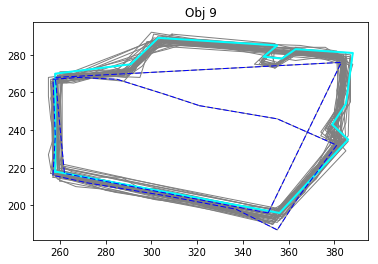

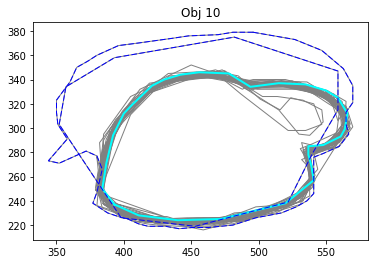

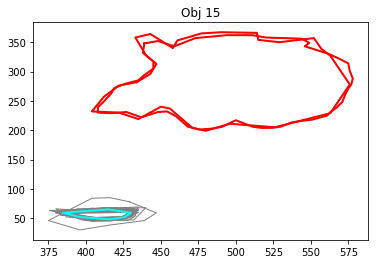

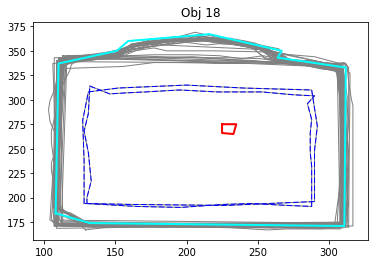

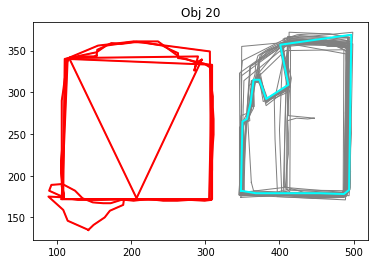

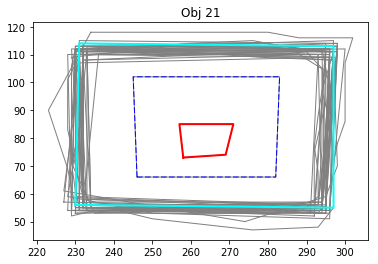

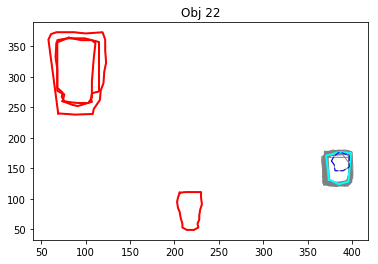

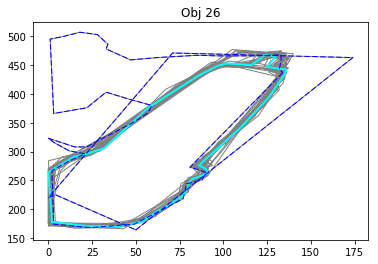

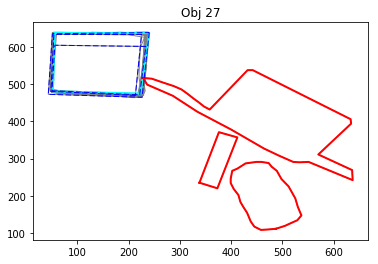

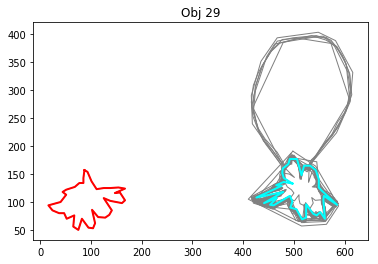

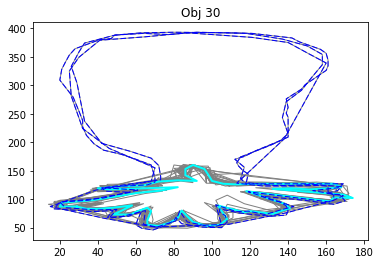

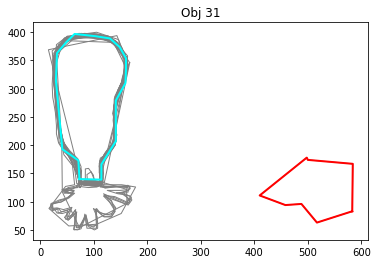

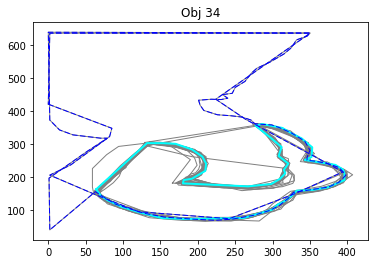

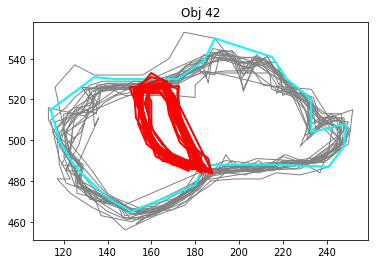

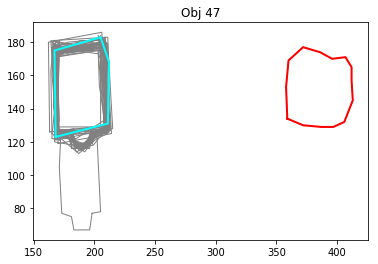

In [16]:
worker_lst = list(set(bad_worker_records[:,0]))
bad_worker_records = np.array(bad_worker_records)
curr_obj = -1
for bad_worker_record in bad_worker_records:
    if curr_obj!=bad_worker_record[0]:
        #print "here"
        curr_obj = bad_worker_record[0]
        bb_objects = bb_info[bb_info["object_id"]==curr_obj]
        plt.figure()
        plt.title("Obj {}".format(curr_obj))
        for widx in bb_objects.worker_id.unique():
            plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True,color="grey",fill_color="")
        plot_coords(ground_truth_T(curr_obj),color="cyan",lw=2,reverse_xy=True,fill_color="")

    widx = bad_worker_record[1]
    err_type = bad_worker_record[2]
    if err_type==1:
        plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True,color="red",lw=2,fill_color="")
    elif err_type==2:
        plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True,color="blue",linestyle='--',fill_color="")

Debugging why algo performs badly on vase/flower examples? 

In [20]:
wids_counts_dict

Counter({3: 18,
         9: 18,
         52: 18,
         72: 62,
         82: 62,
         103: 18,
         114: 62,
         116: 18,
         123: 18,
         131: 18,
         133: 18,
         135: 18,
         139: 18,
         140: 18,
         146: 18,
         147: 62,
         148: 18,
         156: 18,
         169: 18,
         175: 18,
         181: 18,
         184: 62,
         187: 18,
         192: 18,
         193: 18,
         196: 18,
         199: 62,
         205: 62,
         208: 18,
         209: 18,
         214: 18,
         218: 18,
         219: 18,
         225: 18,
         228: 62,
         230: 18,
         234: 18,
         235: 18,
         239: 18,
         263: 62})

obj 29 : Not Type 2 error
False False
obj 30 : Not Type 1 error
obj 31 : Not Type 2 error
True False
obj 32 : Not Type 1 error
obj 32 : Not Type 2 error
False False
obj 33 : Not Type 1 error
obj 33 : Not Type 2 error
True False


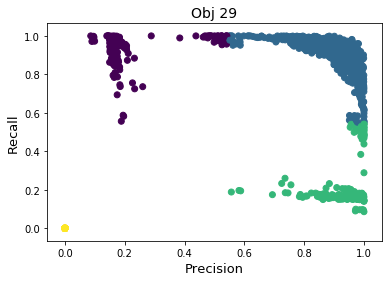

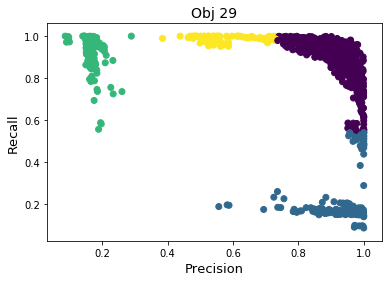

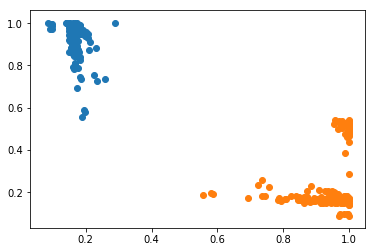

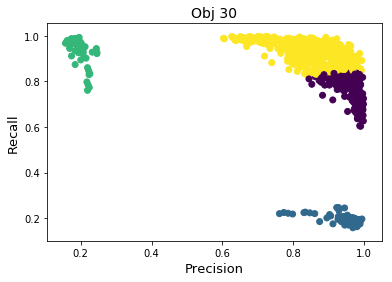

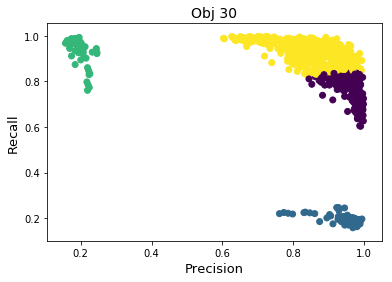

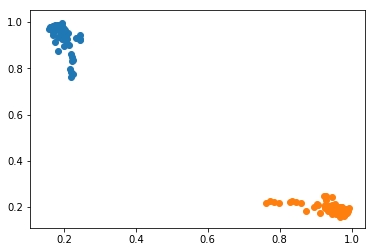

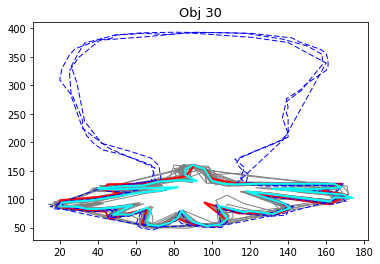

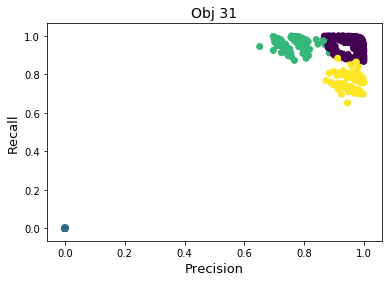

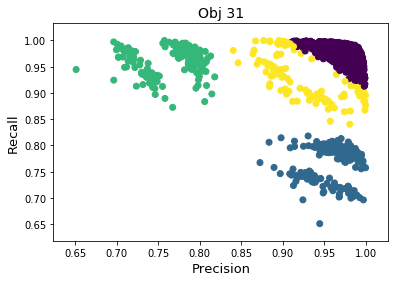

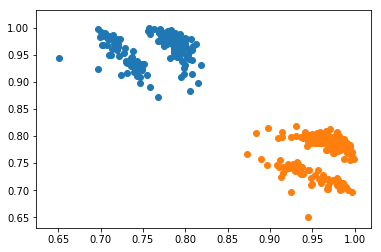

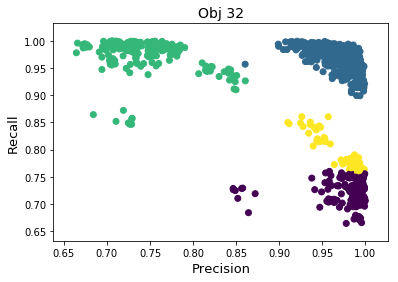

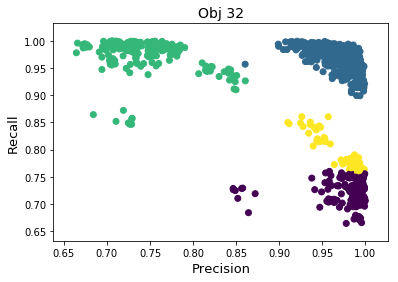

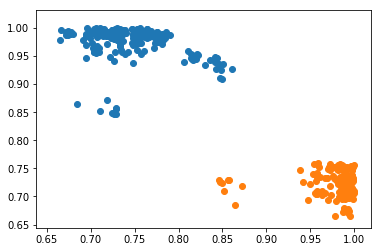

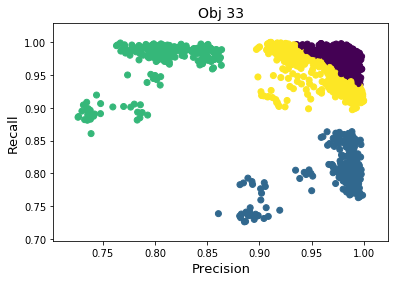

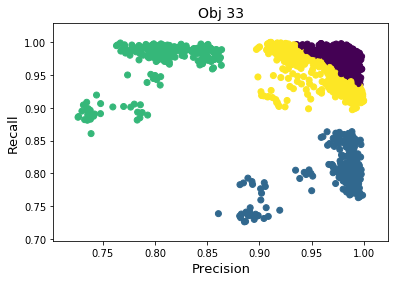

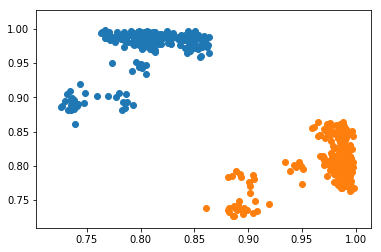

In [19]:
PLOT = True
bad_worker_records =[]
for obj in object_lst[28:33]:
    type1_error_flag=False
    # First pass, get rid of type 1 error
    prj_matrix,worker_ijdxs = compute_prjs(obj)
    kmeans,ypred = cluster(obj,prj_matrix,PLOT=PLOT)
    bb_objects = bb_info[bb_info["object_id"]==obj]
    type1_error_cluster = np.where(kmeans.cluster_centers_[:,2]<0.1)[0]
    if len(type1_error_cluster)==0:
        print "obj",obj,": Not Type 1 error"
    else:
        type1_error_flag=True
        type1_error_wids = np.where(ypred==type1_error_cluster[0])[0]
        wids_counts_dict = Counter(worker_ijdxs[type1_error_wids].flatten())
        mode = scipy.stats.mode(wids_counts_dict.values()).mode[0]
        bad_idx = np.where(wids_counts_dict.values()!=mode)[0]
        bad_widx1 = np.array(wids_counts_dict.keys())[bad_idx]
        
        for bwidx in bad_widx1:
            bad_worker_records.append([obj,bwidx,1]) #obj,bad worker id, error type 1

    # Second pass, get rid of type 2 error
    if type1_error_flag:
        prj_matrix,worker_ijdxs = compute_prjs(obj,exclude_lst=bad_widx1)
    else:
        prj_matrix,worker_ijdxs = compute_prjs(obj)
    kmeans,ypred = cluster(obj,prj_matrix,PLOT=PLOT)
    bb_objects = bb_info[bb_info["object_id"]==obj]
    i = kmeans.cluster_centers_[:,0].argmin() #lowest precision cluster
    j = kmeans.cluster_centers_[:,1].argmin() #highest precision cluster

    idx = np.where(ypred==i)[0]
    jdx = np.where(ypred==j)[0]
    if PLOT: 
        plt.figure()
        plt.scatter(prj_matrix[idx,0],prj_matrix[idx,1])
        plt.scatter(prj_matrix[jdx,0],prj_matrix[jdx,1])

    all_bad_worker_pairs = np.concatenate([worker_ijdxs[idx],worker_ijdxs[jdx]])
    wids_counts_dict = Counter(all_bad_worker_pairs.flatten())
    # Type 2 object errors where only a few workers make mistake are often in the form of high number of modes with a few mistaken worker having very high count
    count_of_voted_pairs = Counter(wids_counts_dict.values())

    total_datapoints_in_bad_clusters = len(all_bad_worker_pairs)*2
    # Two criterions to check for whether it is type 2 error or not
    flag1 = len(count_of_voted_pairs)<4 #number of distinct values is less than 4
    flag2= max(count_of_voted_pairs.keys())> total_datapoints_in_bad_clusters*0.1 #the large counts must be larger than 10% of the total datapoints in the bad clusters

    if flag1 and flag2:
        mode = scipy.stats.mode(wids_counts_dict.values()).mode[0]
        bad_idx = np.where(wids_counts_dict.values()!=mode)[0]
        bad_widx2 = np.array(wids_counts_dict.keys())[bad_idx]
        
        if type1_error_flag:
            bad_widx = np.concatenate([bad_widx1,bad_widx2])
        else:
            bad_widx = bad_widx2
        good_widx = [wid for wid in bb_objects.worker_id.unique() if wid not in bad_widx ]
        if PLOT:
            plt.figure()
            plt.title("Obj {}".format(obj),fontsize=13)
            for widx in good_widx:
                plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True,color="grey",fill_color="")
            for widx in bad_widx1:
                plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True,color="red",lw=2,fill_color="")
            for widx in bad_widx2:
                plot_coords(worker_polygon(bb_objects,widx),reverse_xy=True,color="blue",linestyle='--',fill_color="")
            plot_coords(ground_truth_T(obj),color="cyan",lw=2,reverse_xy=True,fill_color="")

        for bwidx in bad_widx2:
            bad_worker_records.append([obj,bwidx,2]) #obj,bad worker id, error type 2
    else:
        print "obj",obj,": Not Type 2 error"
        print flag1,flag2
# df = pd.DataFrame(bad_worker_records,columns=["objid","bad worker id","error type"])
# df.to_csv("bad_worker_records.csv")